In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

df_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


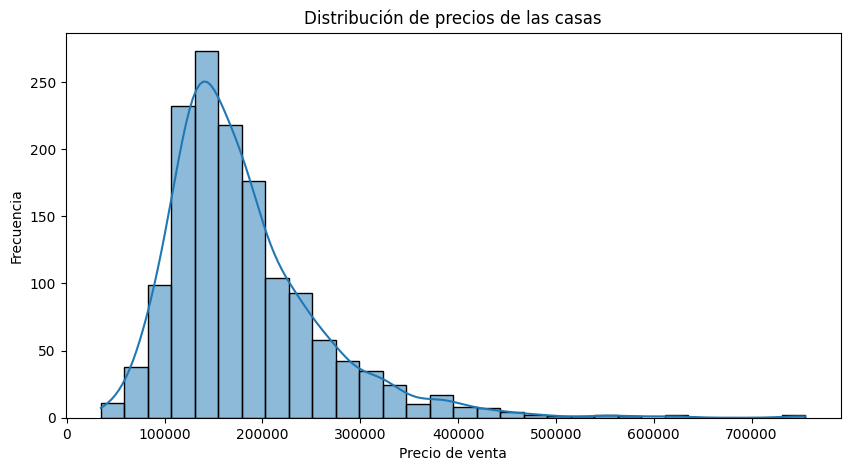

Límite Económicas: 139000.0
Límite Intermedias: 189893.00000000006


In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train['SalePrice'], bins=30, kde=True)
plt.title("¿Cómo están los precios de las casas?")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

low_price = df_train['SalePrice'].quantile(0.33)
mid_price = df_train['SalePrice'].quantile(0.66)

print(f"Casas económicas: hasta {low_price}")
print(f"Casas intermedias: entre {low_price} y {mid_price}")
print(f"Casas caras: más de {mid_price}")


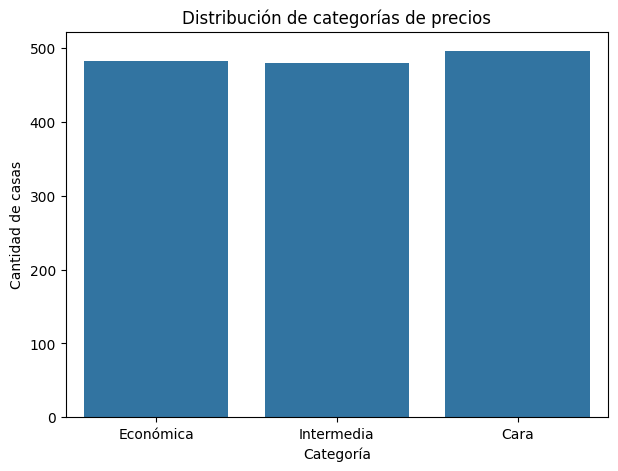

CategoriaPrecio
Cara          497
Económica     483
Intermedia    480
Name: count, dtype: int64

In [ ]:
def categorizar_casas(precio):
    if precio <= low_price:
        return "Barata"
    elif precio <= mid_price:
        return "Normal"
    else:
        return "Cara"

df_train['Categoria'] = df_train['SalePrice'].apply(categorizar_casas)

plt.figure(figsize=(7, 5))
sns.countplot(x=df_train['Categoria'], order=["Barata", "Normal", "Cara"])
plt.title("Cantidad de casas en cada categoría")
plt.xlabel("Tipo de casa")
plt.ylabel("Número de casas")
plt.show()

df_train['Categoria'].value_counts()


In [ ]:
columnas_utiles = ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt", "LotArea"]

X = df_train[columnas_utiles]
y = df_train["Categoria"]

# Categorica a numerica
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")


Tamaño de entrenamiento: (1168, 7)
Tamaño de prueba: (292, 7)


In [ ]:
modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(X_train, y_train)

score_train = modelo.score(X_train, y_train)
score_test = modelo.score(X_test, y_test)

print(f"Precisión en entrenamiento: {score_train:.2f}")
print(f"Precisión en prueba: {score_test:.2f}")


Precisión en entrenamiento: 0.80
Precisión en prueba: 0.74


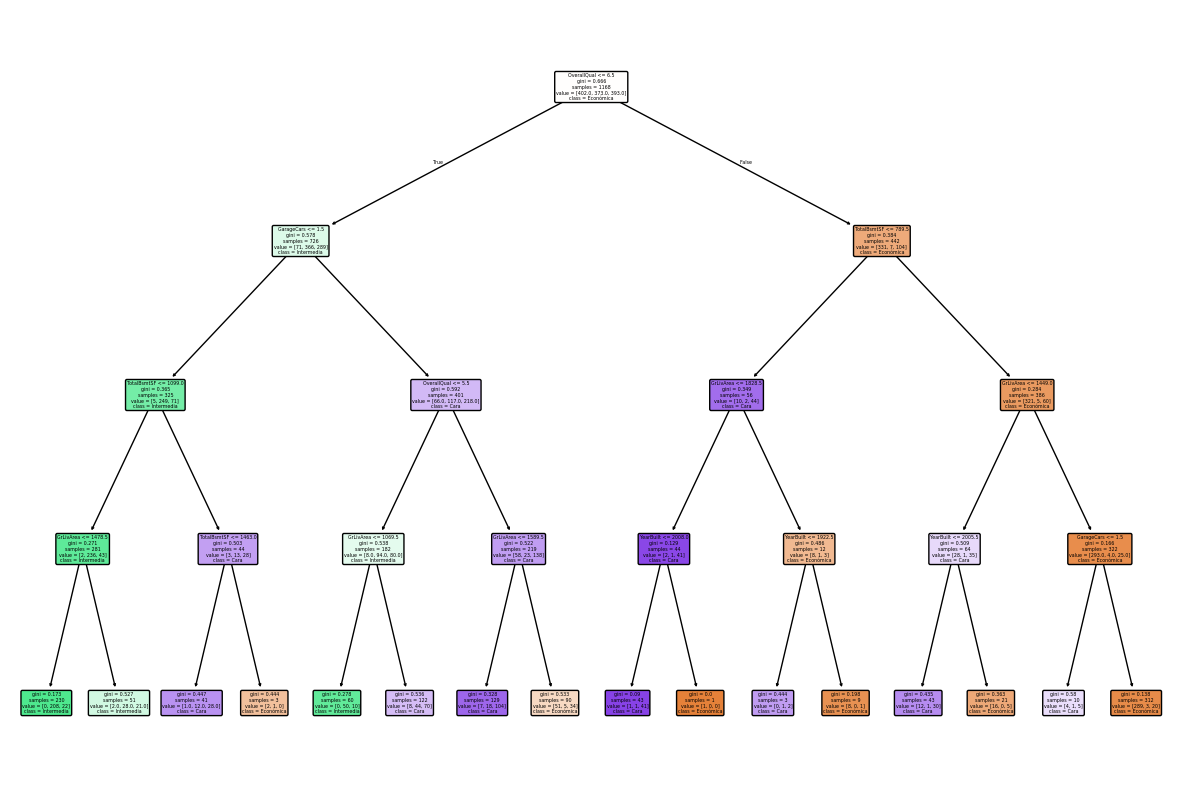

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(modelo, feature_names=X.columns, class_names=["Barata", "Normal", "Cara"], filled=True, rounded=True)
plt.show()
